In [1]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt


import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
from importlib import reload
import tqdm
import pickle
%matplotlib inline


import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20190408/


In [2]:
# Set up birds and block_paths
birds = ['B1083', 'B1083-2', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1083-2': '/home/brad/krista/B1083/P03S05'}

bird = 'B1083'
block_path = bps[bird]

# Parameters for binning
winsize = 10.0               # binning window size in milliseconds
dtovr = winsize*0.5          # window overlap in milliseconds
comment = 'ForSCM'         # We're plotting betti curves
segment_info = [0,0]       # We want the whole stimulus and just the stimulus

# Parameters for Betti curve computation
thresh = 13.0                            # Activation threshold
nperms = None                            # No permutations of the population - use full pop
ncellsperm = 20                          # Number of cells to subsample for each permuation
dims = [0,1,2,3,4]                        # Compute first five betti numbers
Ntimes = 1000                            # Number of interpolation points
stimlen = 6000                           # Stimulus length in milliseconds
twin = np.linspace(0, stimlen, Ntimes)   # Vector of interpolation time points


In [3]:
# Bin the data from each bird
bdfs = {}
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20170829T191155Z-10.0-5.0.binned
Data Not already binned
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
Nreps = 20
skip = 100
dur = 120000.0
nwins = 1200
/home/brad/krista/B1083/P03S05/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20190408T161236Z-10.0-5.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T185704Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T220619Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-

In [4]:
reload(tp2)
bc_tavg_store = {}
t_store = {}
tms_store = {}
bc_tavg_shuff_store = {}

for bird in birds:
    bdf = bdfs[bird]
    block_path = bps[bird]
    # compute real and shuffled betti curves - TrialAverage
    print('Computing trial average')
    (bc_tavg, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr)
    (bc_tavg_shuff, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr, shuffle=True)
    bc_tavg_store[bird] = bc_tavg
    bc_tavg_shuff_store[bird] = bc_tavg_shuff
    t_store[bird] = t
    tms_store[bird] = tms

Computing trial average
Computing trial average
Computing trial average
Computing trial average
Computing trial average


In [5]:
def plot_scm_distribution(scm_bettis, trial, bettinum, maxbin=200, ax=None, **kwargs):
    nmaxtot = 0
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    bettivals2 = []
    for x in bettivals:
        if type(x) is not list:
            bettivals2.append(x)
        else:
            bettivals2.append(x[0])
    #print(bettivals)
    maxbettival = np.amax(bettivals2)
    maxbin = round(1.5*maxbettival)
    print(maxbin)
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettivals2, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

def plot_scm_distrib(scm_bettis, bettinum, maxbin=200, ax=None, **kwargs):
    
    nmaxtot = 0
    
    bettis = scm_bettis[:, 0, bettinum]
    bettis = bettis[bettis >=0]
    #print(bettis)
    maxbettival = np.amax(bettis)
    maxbin = round(1.5*(maxbettival+1))
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettis, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

In [ ]:
# average over all trials
import tqdm
nsamples = 200
bird_scm_dict = {}
for bird in birds:
    bdf = bdfs[bird]
    stim_dict = {}
    stim_shuffled_dict = {}
    stim_scm_dict = {}
    stim_betticurve_dict = {}
    stim_shuffled_betticurve_dict = {}
    with h5.File(bdf, 'r') as bdff:
        stims = bdff.keys()
        for stim in tqdm.tqdm(stims):
            #print(stim)
            trial=0
            stim_poptens = tp2.extract_population_tensor(bdf, stim)
            ntrials = tp2.num_trials(stim_poptens)
            stim_scm_dat= []
            stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]     
            scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
            stim_scm_dict[stim] = scm_bettis
    bird_scm_dict[bird] = stim_scm_dict


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



1it [13:08, 788.79s/it]
2it [13:09, 394.63s/it]
3it [13:09, 263.26s/it]
4it [13:10, 197.57s/it]
5it [13:10, 158.16s/it]
6it [13:11, 131.87s/it]
7it [13:11, 113.10s/it]
8it [13:12, 99.01s/it] 
9it [13:12, 88.06s/it]
10it [13:12, 79.30s/it]
11it [13:13, 72.13s/it]
12it [13:13, 66.16s/it]
13it [13:14, 61.11s/it]
14it [13:14, 56.78s/it]
15it [13:15, 53.02s/it]
16it [13:15, 49.74s/it]
17it [13:16, 46.84s/it]
18it [13:16, 44.26s/it]
19it [13:17, 41.96s/it]
20it [13:17, 39.89s/it]
21it [13:18, 38.01s/it]
22it [13:18, 36.30s/it]
23it [13:19, 34.75s/it]
24it [13:19, 33.32s/it]
25it [13:20, 32.01s/it]
26it [13:20, 30.80s/it]
27it [13:21, 29.68s/it]
28it [13:21, 28.64s/it]
29it [13:22, 27.67s/it]
30it [13:22, 26.76s/it]
31it [13:23, 25.91s/it]
32it [13:23, 25.11s/it]
33it [13:24, 24.37s/it]
34it [13:24, 23.67s/it]
35it [13:25, 23.00s/it]
36it [13:25, 22.38s/it]
37it [13:25, 21.78s/it]
38it [13:26, 21.22s/it]
39it [13:26, 20.69s/it]
40it [13:27, 20.19s/it]
41it [13:27, 19.70s/it]
42it [13:28, 19.

Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [09:25, 565.70s/it]
2it [09:25, 282.91s/it]
3it [09:25, 188.64s/it]
4it [09:26, 141.51s/it]
6it [09:26, 94.37s/it] 
7it [09:26, 80.90s/it]
8it [09:26, 70.80s/it]
9it [09:26, 62.95s/it]
10it [09:26, 56.67s/it]
11it [09:26, 51.52s/it]
12it [09:26, 47.24s/it]
13it [09:26, 43.61s/it]
14it [09:27, 40.51s/it]
15it [09:27, 37.81s/it]
16it [09:27, 35.46s/it]
17it [09:27, 33.38s/it]
18it [09:27, 31.53s/it]
19it [09:27, 29.88s/it]
20it [09:27, 28.39s/it]
22it [09:27, 25.82s/it]
24it [09:28, 23.67s/it]
26it [09:28, 21.86s/it]
28it [09:28, 20.30s/it]
30it [09:28, 18.96s/it]
32it [09:28, 17.78s/it]
34it [09:29, 16.74s/it]
35it [09:29, 16.27s/it]
37it [09:29, 15.39s/it]
39it [09:29, 14.61s/it]
40it [09:29, 14.24s/it]
42it [09:29, 13.57s/it]
44it [09:30, 12.96s/it]
45it [09:30, 12.67s/it]
46it [09:30, 12.40s/it]
48it [09:30, 11.89s/it]
49it [09:30, 11.65s/it]
50it [09:30, 11.42s/it]
51it [09:30, 11.19s/it]
52it [09:31, 10.98s/it]
53it [09:31, 10.78s/it]
54it [09:31, 10.58s/it]
55it [09:31, 10.39

Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



1it [09:38, 578.78s/it]
2it [09:38, 289.48s/it]
3it [09:39, 193.05s/it]
4it [09:39, 144.84s/it]
5it [09:39, 115.91s/it]
6it [09:39, 96.62s/it] 
7it [09:39, 82.84s/it]
8it [09:40, 72.51s/it]
9it [09:40, 64.47s/it]
10it [09:40, 58.05s/it]
11it [09:40, 52.79s/it]
12it [09:40, 48.40s/it]
13it [09:41, 44.69s/it]
14it [09:41, 41.51s/it]
15it [09:41, 38.76s/it]
16it [09:41, 36.35s/it]
17it [09:41, 34.22s/it]
18it [09:41, 32.33s/it]
19it [09:42, 30.64s/it]
20it [09:42, 29.12s/it]
21it [09:42, 27.74s/it]
22it [09:42, 26.49s/it]
23it [09:42, 25.34s/it]
24it [09:43, 24.30s/it]
25it [09:43, 23.33s/it]
26it [09:43, 22.44s/it]
27it [09:43, 21.62s/it]
28it [09:43, 20.85s/it]
29it [09:44, 20.14s/it]
30it [09:44, 19.48s/it]
31it [09:44, 18.85s/it]
32it [09:44, 18.27s/it]
33it [09:44, 17.72s/it]
34it [09:45, 17.21s/it]
35it [09:45, 16.72s/it]
36it [09:45, 16.26s/it]
37it [09:45, 15.83s/it]
38it [09:45, 15.42s/it]
39it [09:45, 15.02s/it]
40it [09:46, 14.65s/it]
41it [09:46, 14.30s/it]
42it [09:46, 13.97

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None


In [ ]:
import pickle
with open(os.path.join(figsavepth,'scm_control_save_trialvg_ALL.pkl'), 'wb') as f:
    pickle.dump(bird_scm_dict, f)

In [9]:
bird_scm_dict.keys()

dict_keys(['B1083', 'B1056', 'B1235', 'B1075'])

111.0
Stim: I_40k Betti: 1  p-value: 0.09289617486338797
140.0
Stim: J_40k Betti: 1  p-value: 0.0
93.0
Stim: K_40k Betti: 1  p-value: 0.06000000000000005
100.0
Stim: L_40k Betti: 1  p-value: 0.005128205128205128
168.0
Stim: M_40k Betti: 1  p-value: -0.005154639175257714
108.0
Stim: N_40k Betti: 1  p-value: 0.2717948717948718
204.0
Stim: O_40k Betti: 1  p-value: -0.004999999999999893
176.0
Stim: P_40k Betti: 1  p-value: -0.004999999999999893
322.0
Stim: I_40k Betti: 2  p-value: -0.005464480874316946
220.0
Stim: J_40k Betti: 2  p-value: -0.004999999999999893
309.0
Stim: K_40k Betti: 2  p-value: -0.004999999999999893
166.0
Stim: L_40k Betti: 2  p-value: -0.00512820512820511
264.0
Stim: M_40k Betti: 2  p-value: -0.005154639175257714
346.0
Stim: N_40k Betti: 2  p-value: -0.00512820512820511
50.0
Stim: O_40k Betti: 2  p-value: 0.055
96.0
Stim: P_40k Betti: 2  p-value: 0.08499999999999996


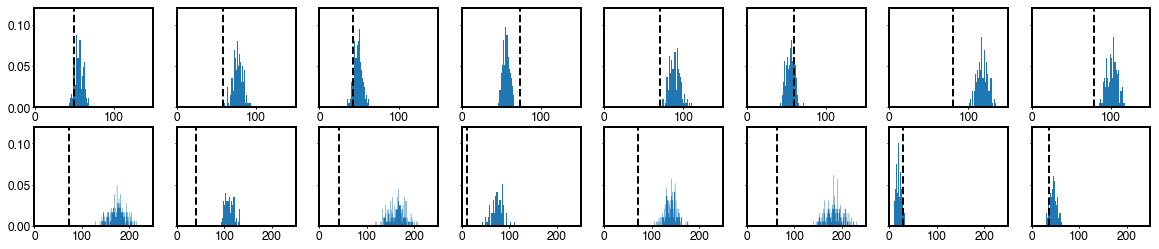

In [23]:
# Single bird

bird = 'B1083'
stim_scm_dict = bird_scm_dict[bird]
bc_tavg = bc_tavg_store[bird]

plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
f, axs = plt.subplots(2, 8,figsize=(20, 4), sharey=True, sharex=False)
betti_num = 3
bettis = [1,2]
stims = list(bc_tavg.keys())[0:8]
my = 0
for ind, betti_num in enumerate(bettis):
    nmaxyt = 0
    nmaxxt = 0
    for stimind, stim in enumerate(stims):
        final_bettis = bc_tavg[stim][:, -1, 0]
        ax = axs[ind, stimind]
        #final_bettis = stim_betticurve_dict[stim][-1]
        b = final_bettis[betti_num]
        ax.plot([b, b], [0, 100], 'k--', linewidth=2)
        (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
        nmaxyt = np.amax([nmaxy, nmaxyt])
        nmaxxt = np.amax([nmaxx, nmaxxt])
        if ind > 0:
            xmax = 250
            
            ax.set_xticks(np.arange(0, 300, 100))
        else:
            xmax = 150
    
        ax.set_xlim([-0.1, xmax])
        ax.set_ylim([0, 0.12])
        ax.tick_params(labelsize=12)
        for i in ax.get_xticklabels():
            i.set_fontname('helvetica')
        for i in ax.get_yticklabels():
            i.set_fontname('helvetica')
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
            
        # Calculate empirical p-values
        betti_vals = stim_scm_dict[stim][:, 0, betti_num]
        betti_vals = betti_vals[betti_vals >= 0]
        p = (1+np.sum(b <= betti_vals)) / (len(betti_vals + 1))
        if p > 0.5:
            p = 1-p
        print('Stim: {} Betti: {}  p-value: {}'.format(stim, betti_num, p))
            
        
        #ax.set_title(stim)
plt.savefig(os.path.join(figsavepth, 'SCMControl{}_bettiAll_8stims.eps'.format(bird)))

111.0
140.0
93.0
100.0
168.0
108.0
204.0
176.0
322.0
220.0
309.0
166.0
264.0
346.0
50.0
96.0
117.0
111.0
68.0
135.0
134.0
116.0
116.0
136.0
18.0
21.0
76.0
6.0
4.0
10.0
32.0
3.0
45.0
63.0
69.0
51.0
81.0
32.0
62.0
34.0
112.0
51.0
44.0
99.0
34.0
122.0
39.0
128.0
86.0
40.0
60.0
98.0
116.0
63.0
76.0
80.0
12.0
10.0
58.0
8.0
3.0
46.0
28.0
4.0


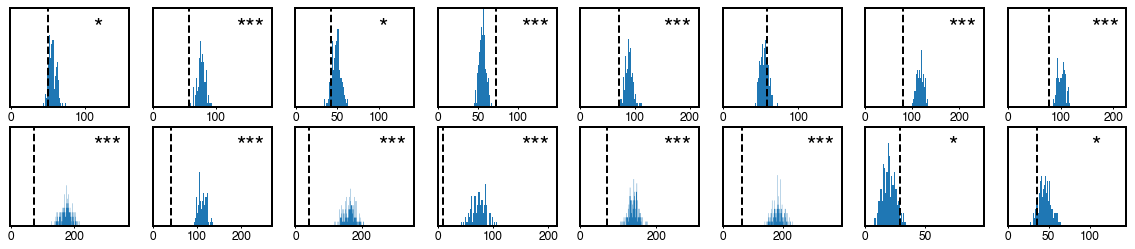

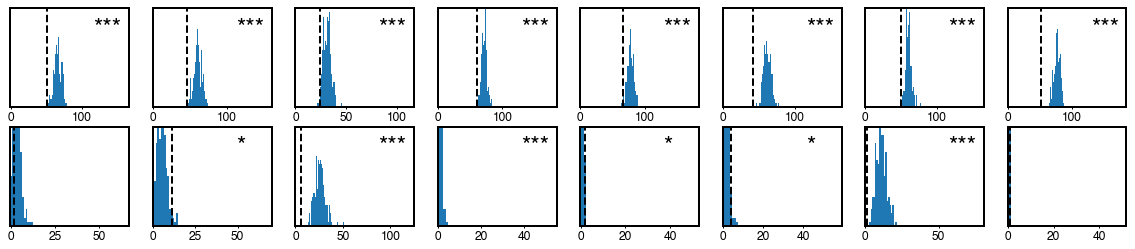

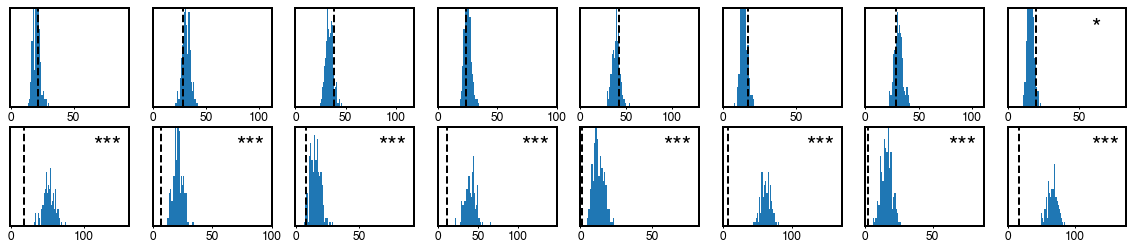

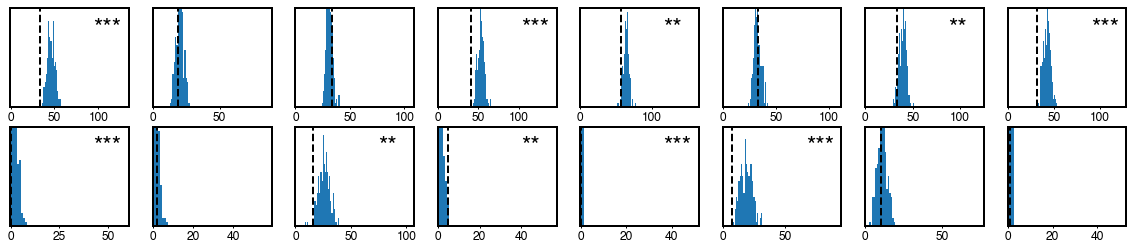

In [39]:
# All bird

for bird in birds:
    stim_scm_dict = bird_scm_dict[bird]
    bc_tavg = bc_tavg_store[bird]

    plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
    f, axs = plt.subplots(2, 8,figsize=(20, 4), sharey=True, sharex=False)
    betti_num = 3
    bettis = [1,2]
    stims = list(bc_tavg.keys())[-8:]
    my = 0
    for ind, betti_num in enumerate(bettis):
        nmaxyt = 0
        nmaxxt = 0
        for stimind, stim in enumerate(stims):
            final_bettis = bc_tavg[stim][:, -1, 0]
            ax = axs[ind, stimind]
            #final_bettis = stim_betticurve_dict[stim][-1]
            b = final_bettis[betti_num]
            ax.plot([b, b], [0, 100], 'k--', linewidth=2)
            (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled')
            nmaxyt = np.amax([nmaxy, nmaxyt])
            nmaxxt = np.amax([nmaxx, nmaxxt])
            
            if ind > 0:
                xmax = nmaxx+50

                #ax.set_xticks(np.arange(0, 300, 100))
            else:
                xmax = nmaxx+50

            ax.set_xlim([-0.1, xmax])
            ax.set_ylim([0, 0.12])
            ax.tick_params(labelsize=12)
            for i in ax.get_xticklabels():
                i.set_fontname('helvetica')
            for i in ax.get_yticklabels():
                i.set_fontname('helvetica')
            for axis in ['top', 'bottom', 'left', 'right']:
                ax.spines[axis].set_linewidth(2)
            ax.get_yaxis().set_visible(False)
            # Calculate empirical p-values
            betti_vals = stim_scm_dict[stim][:, 0, betti_num]
            betti_vals = betti_vals[betti_vals >= 0]
            p = (1+np.sum(b <= betti_vals)) / (len(betti_vals + 1))
            stars = ''
            if p > 0.5:
                p = 1-p
            if p < 0.1:
                stars = '*'
            if p < 0.05:
                stars = '**'
            if p < 0.01:
                stars = '***'
            ax.text(0.7, 0.75, stars, transform=ax.transAxes, fontsize=24)
            #print('Stim: {} Betti: {}  p-value: {}'.format(stim, betti_num, p))


            #ax.set_title(stim)
    plt.savefig(os.path.join(figsavepth, 'SCMControl{}_bettiAll_8stims.pdf'.format(bird)))